## Program pengenalan citra wajah

### Arahkan colaboratory pada file project yang ingin dijalankan

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd gdrive/My\ Drive/simple-face-recognition
!ls

/content/gdrive/My Drive/simple-face-recognition
dataset		      FaceRecognition.ipynb	 output
dataset2	      FaceRecognition-v2.ipynb	 recognize_video.py
embeddings.txt	      images			 registrasi-training.ipynb
face_detection_model  openface_nn4.small2.v1.t7  registrasi-training-v2.ipynb


### Import libraries yang dibutuhkan

In [0]:
import numpy as np
import argparse
import imutils
import cv2
import os
import matplotlib.pyplot as plt
import json
import sys

### Load Bank fitur yang sudah didapatkan dari proses sebelumnya

In [0]:
f = open('embeddings.txt', 'r')
data_set = json.loads(f.read())
f.close()

### Model pendeteksi wajah

In [0]:
protoPath = 'face_detection_model/deploy.prototxt'
modelPath = 'face_detection_model/res10_300x300_ssd_iter_140000.caffemodel'
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

### Model pengekstraksi fitur

In [0]:
embedding_model = 'openface_nn4.small2.v1.t7';
embedder = cv2.dnn.readNetFromTorch(embedding_model)

### Membuat fungsi yang mencari jarak antara image yang akan dites dengan ID yang ada di Bank fitur

In [0]:
def searchID(features_arr, thres = 0.6, percent_thres = 70):
    returnRes = [];
    result = "Unregistered";
    smallest = sys.maxsize
    for person in data_set.keys():
        person_data = data_set[person];
        distance = np.sqrt(np.sum(np.square(person_data-features_arr)))
        if(distance < smallest):
            smallest = distance;
            result = person;
    percentage =  min(100, 100 * thres / smallest)
    if percentage <= percent_thres :
        result = "Unregistered"
    returnRes.append((result,percentage))
    return returnRes

### Preprocessing data yang akan dites

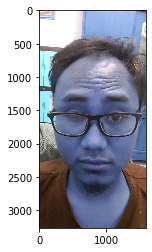

In [29]:
# load the image, resize it to have a width of 600 pixels (while maintaining the aspect ratio), and then grab the image dimensions
image = 'images/bariqi.jpg'
image = cv2.imread(image)
# image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),	(104.0, 177.0, 123.0), swapRB=False, crop=False)

# apply OpenCV's deep learning-based face detector to localize faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()
box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
(startX, startY, endX, endY) = box.astype("int")
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
plt.imshow(image)

### Proses testing

In [30]:
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the
		# face
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# extract the face ROI
		face = image[startY:endY, startX:endX]
		(fH, fW) = face.shape[:2]

		# ensure the face width and height are sufficiently large
		if fW < 20 or fH < 20:
			continue

		# construct a blob for the face ROI, then pass the blob through our face embedding model to obtain the 128-d quantification of the face
		faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),	(0, 0, 0), swapRB=True, crop=False)
		embedder.setInput(faceBlob)
		vec = embedder.forward()

		features_arr = vec.flatten()
		recog_data = searchID(features_arr)
		print(recog_data)

		# draw the bounding box of the face along with the associated probability
		text = "{}: {:.2f}%".format(recog_data[0][0], recog_data[0][1])
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),	cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

[('nicholas saputra', 100)]
[('nicholas saputra', 86.95551018413207)]


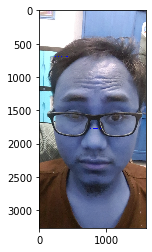

In [32]:
# show the output image
plt.imshow(image)